<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Sequence-to-Sequence RNN Models: Translation Task


Estimated time needed: **120** minutes


In this hands-on guide, you will explore the fundamentals of sequence-to-sequence models and learn how to implement an RNN-based model for a translation task using PyTorch.


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
        </ol>
    </li>
    <li>
        <a href="#Background">Background</a>
        <ol>
            <li><a href="#History-of-sequence-to-sequence-models">History of sequence-to-sequence models</a></li>
            <li><a href="#Introduction-to-RNNs">Introduction to RNNs</a></li>
            <li><a href="#Sequence-to-sequence-architecture">Sequence-to-sequence architecture</a></li>    
        </ol>
    <li><a href="#Encoder-implementation-in-PyTorch">Encoder implementation in PyTorch</a></li>
    <li><a href="#Decoder-implementation-in-PyTorch">Decoder implementation in PyTorch</a></li>
    <li><a href="#Sequence-to-sequence-model-implementation-in-PyTorch">Sequence-to-sequence model implementation in PyTorch</a>
    <li><a href="#Training-model-in-PyTorch">Training model in PyTorch</a></li>
    <li><a href="#Evaluating-model-in-PyTorch">Evaluating model in PyTorch</a></li>
    <li><a href="#Data-preprocessing">Data preprocessing</a></li>
    <li><a href="#Training-the-model">Training the model</a></li>
    <ol>
        <li><a href="#Initializations">Initializations</a></li>
        <li><a href="#Training">Training</a></li>
    </ol>
    <li><a href="#Model-inference">Model inference</a></li>
    <li><a href="#BLEU-score-metric-for-evaluation">BLEU score metric for evaluation</a></li>
    <li><a href="#Exercises">Exercises</a></li>

</ol>


## Objectives
After completing this lab, you will be able to:

 - Comprehend recurrent neural networks (RNN) architecture
 - Create an Encoder-Decoder model for a translation task
 - Train and evaluate the model
 - Create a generator for the translation task
 - Explain concepts related to Perplexity and BLEU score and use them for evaluating translations


----


## Setup


### Installing required libraries

<h2 style="color:red;">After installing the libraries below please RESTART THE KERNEL and run all cells.</h2>


In [1]:
# %%capture
# !pip install torch==2.2.2
# !pip install torchtext==0.17.2
# !pip install portalocker==2.8.2
# !pip install torchdata==0.7.1
# !pip install pandas
# !pip install matplotlib==3.9.0 scikit-learn==1.5.0
# !pip install numpy==1.26.0
# !pip install spacy
# !pip install nltk

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


In [2]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

### Importing required libraries

_It is recommended that you import all required libraries in one place (here):_


In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchdata.datapipes.iter import IterableWrapper, Mapper
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from nltk.translate.bleu_score import sentence_bleu
import torch
import torch.nn as nn
import torch.optim as optim


import numpy as np
import random
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import urllib.request


# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

## Background

Sequence-to-sequence (Seq2seq) models have revolutionized various natural language processing (NLP) tasks, such as machine translation, text summarization, and chatbots. These models employ Recurrent Neural Networks (RNNs) to process variable-length input sequences and generate variable-length output sequences.


### History of sequence-to-sequence models

Sequence-to-sequence models were introduced as an extension of traditional feedforward neural networks.
Researchers realized the need for models that could handle variable-length input and output sequences, such as machine translation.
The pioneering work of Sutskever et al. (2014) introduced the use of RNNs for seq2seq models.

Here are some main objectives of seq2seq models:
- Translation: Translating a sequence from one domain to another (e.g., English to French).
- Question answering: Generating a natural language response given an input sentence (e.g., chatbots).
- Summarization: Summarizing a long document into a shorter sequence of sentences.
And many more applications that involve sequence generation.


### Introduction to RNNs

RNNs are a class of neural networks designed to process sequential data.
They maintain an internal memory($h_t$) to capture information from previous steps and use it for current predictions.
RNNs have a recurrent connection that allows information to flow from one step to the next.
Recurrent Neural Networks (RNNs) operate on sequences and utilize previous states to influence the current state. Here's the general formulation of a simple RNN:


Given:

-$ \mathbf{x}_t $: input vector at time step $t$

-$ \mathbf{h}_{t-1} $: hidden state vector from the previous time step

-$ \mathbf{W}_x $ and $ \mathbf{W}_h $: weight matrices for the input and hidden state, respectively

-$ \mathbf{b} $: bias vector

-$\sigma$: activation function (often a sigmoid or tanh)

The update equations for the hidden state $ \mathbf{h}_t $ and the output $ \mathbf{y}_t $ are as follows:

$$
\begin{align*}
\mathbf{h}_t &= \sigma(\mathbf{W}_x \cdot \mathbf{x}_t + \mathbf{W}_h \cdot \mathbf{h}_{t-1} + \mathbf{b})
\end{align*}
$$

It can be seen that the hidden state function depends on the previous hidden state as well as the input at time t, which is why it has a collective memory of previous time steps.

For the output (if you're making a prediction at each time step):

$$
\begin{align*}
\mathbf{y}_t &= \text{softmax}(\mathbf{W}_o \cdot \mathbf{h}_t + \mathbf{b}_o)
\end{align*}
$$

Where:

$ \mathbf{W}_o $: weight matrix for the output AND $ \mathbf{b}_o$: bias vector for the output



Depending on the specific task, an RNN cell can either produce an output from $h_t$ or solely transfer it to the succeeding cell, serving as internal memory. While the architecture's ability to retain memory might seem elusive at first glance, let's elucidate this by implementing a simple RNN to handle the following data mechanism:

![a title](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Screenshot%202023-10-19%20at%2011.29.23%E2%80%AFAM.png)


The diagram showcases a state machine or transition model with three distinct states, depicted by the prominent purple circles. Each state is distinctly labeled with a value for $ h $: $ h = -1 $, $ h = 0 $, and $ h = 1 $.

1. **State $ h = -1 $**:
   - Maintains itself when $ x = 1 $ (illustrated by the yellow loop).
   - Proceeds to the $ h = 0$ state upon receiving $ x = -1$ (highlighted by the red arrow).

2. **State $ h = 0 $**:
   - Moves to the $h = -1 $ state when $ x = 1$ (illustrated by the red arrow).
   - Advances to the $ h = 1 $ state with $ x = -1$ (marked by the red arrow).

3. **State $h = 1 $**:
   - Sustains its position when $ x = -1 $ (indicated by the yellow loop).
   - Transitions to the $ h = 0 $ state upon receiving $ x = 1 $ (signified by the red arrow).

To encapsulate, the diagram effectively portrays transitions among three states based on the input $ x $. Contingent on the prevailing state and the input $ x $, the state machine either transitions to a different state or remains stationary.

---



You can represent the previously mentioned state machine using the layer detailed below. Use $tanh$ as the $h$ value should fall between [-1, 1]. Note that you have excluded the output for simplification:

$$\begin{align*}
W_{xh} & = -10.0 \\\\\\\\\\\\\\\\\\\\\\
W_{hh} & = 10.0 \\
b_h & = 0.0 \\
x_t & = 1 \\
h_{\text{prev}} & = 0.0 \\
h_t & = \tanh(x_t \cdot W_{xh} + h_{\text{prev}} \cdot W_{hh} + b_h)
\end{align*}$$


In [4]:
 W_xh=torch.tensor(-10.0)
 W_hh=torch.tensor(10.0)
 b_h=torch.tensor(0.0)
 x_t=1
 h_prev=torch.tensor(-1)

Consider the following sequence $x_t$ for  $t=0,1,..,7$,


In [5]:
X=[1,1,-1,-1,1,1]

Assuming that you start from the intial state $h = 0$,  with the above input vector $x$, the state vector $h$ should look like this:


In [6]:
H=[-1,-1,0,1,0,-1]

In [7]:
# Initialize an empty list to store the predicted state values
H_hat = []
# Loop through each data point in the input sequence X
t=1
for x in X:
    # Assign the current data point to x_t
    print("t=",t)
    x_t = x
    # Print the value of the previous state (h at time t-1)
    print("h_t-1", h_prev.item())

    # Compute the current state (h at time t) using the RNN formula with tanh activation
    h_t = torch.tanh(x_t * W_xh + h_prev * W_hh + b_h)

    # Update h_prev to the current state value for the next iteration
    h_prev = h_t

    # Print the current input value (x at time t)
    print("x_t", x_t)

    # Print the computed state value (h at time t)
    print("h_t", h_t.item())
    print("\n")

    # Append the current state value to the H_hat list after converting it to integer
    H_hat.append(int(h_t.item()))
    t+=1


t= 1
h_t-1 -1
x_t 1
h_t -1.0


t= 2
h_t-1 -1.0
x_t 1
h_t -1.0


t= 3
h_t-1 -1.0
x_t -1
h_t 0.0


t= 4
h_t-1 0.0
x_t -1
h_t 1.0


t= 5
h_t-1 1.0
x_t 1
h_t 0.0


t= 6
h_t-1 0.0
x_t 1
h_t -1.0






You can evaluate the accuracy of the predicted state ```H_hat``` by comparing it to the actual state ```H```. In RNNs, the state $ h_t $ is utilized to predict an output sequence $y_t $ based on the given input sequence $ x_t $.


In [8]:
H_hat

[-1, -1, 0, 1, 0, -1]

In [9]:
H

[-1, -1, 0, 1, 0, -1]

While you have pre-defined the $W_{xh}$ and $W_{hh}$  and $b_h$, in practice these values need to be identified through training on data.


In practice, modifications and enhancements, such as Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU), are often used to address issues like the vanishing gradient problem in basic RNNs.


An LSTM cell has three main components: an input gate, a forget gate, and an output gate.
- The **input gate** controls how much new information should be stored in the cell's memory. It looks at the current input and the previous hidden state and decides which parts of the new input to remember.
- The **forget gate** determines what information should be discarded or forgotten from the cell's memory. It considers the current input and the previous hidden state and decides which parts of the previous memory are no longer relevant.
- The **output gate** determines what information should be outputted from the cell. It looks at the current input and the previous hidden state and decides which parts of the cell's memory to include in the output.

The key idea behind LSTM cells is that they have a separate memory state that can selectively retain or forget information over time. This helps them handle long-range dependencies and remember important information from earlier steps in a sequence.


### Sequence-to-sequence architecture

Seq2seq models have an Encoder-Decoder structure. The encoder encodes the input sequence into a fixed-dimensional representation, often called the context vector($h_t$). The decoder generates the output sequence based on the encoded context vector.


Let's look closer into the encoder and decoder boxes in the video below. Translation is a typical sequence-to-sequence task. The input is a sequence of words in the original language("I love to travel"), while output is its translation in the destination language("J'adore voyager"). As shown in the video, input is fed into the decoder part, one word after another. Each RNN cell receives a word($x_t$) and has an internal memory($h_t$). After processing the input and $h_t$, RNN cell passes an updated context vector($h_{t+1}$) to the next RNN cell. When the end of sentence is reached, the context vector is passed to the decoder part. Decoder cells are also RNN cells that receive context vector and generate the output word by word. Each RNN receives the generated word as well as the updated context vector from its previous cell and generates the next word($y_t$). This architecture allows for generating text without length restrictions.


<video width="640" height="480"
src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Translation_RNN.mp4"
controls>
</video>


## Encoder implementation in PyTorch

To implement the encoder part using Pytorch, you will create the sub-class of the torch.nn.Module class and define the __init__() and __forward__() method.

Let's first define the parameters that are used in __init__() function:
- The `vocab_len` is nothing but the number of unique words present in the vocabulary. After pre-processing the data, you can count the number of unique words in your vocabulary and use that count here. This will be the dimension of the model input.
- The embedding_dim is the output dimension of the embedding vector you need. A good practice is to use 256-512 for sample demo app like you are building here.
- LSTM can indeed be stacked, allowing for multiple layers. In the initial implementation, you will use only one layer. However, to accommodate future flexibility, you will pass the parameter `n_layers` to specify the number of layers in the LSTM.
- `hid_dim` is the dimensionality of the hidden and cell states.
- `dropout` is the amount of dropout to use. This is a regularization parameter to prevent overfitting.

Now, let's look into the layers:
- The Embedding layer takes the input data and outputs the embedding vector, hence the dimension of those needs to be defined as `vocab_len` and `embedding_dim`.
- The LSTM Layer takes the `embedding_dim` as the input data and creates total 3 outputs: `hidden`, `cell` and `output`. Here you need to define the number of neurons you need in LSTM, which is defined using the `hid_dim`.


In the __forward__() function, the Embedding layer is defined that utilizes the `vocab_len` to internally convert the input_batch into a one-hot representation. Next, the LSTM layer receives the embedded input and outputs three vectors: Output, Hidden and cell. As for the encoder, you don't require the output vector from the LSTM as you only pass the context vector(`hidden`+`cell`) to the decoder block. Therefore, forward() only returns hidden and cell.

Note: When using an LSTM, you have an additional cell state. However, if you were using a GRU, you would only have the hidden state.


In [10]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, emb_dim, hid_dim, n_layers, dropout_prob):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_len, emb_dim)

        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        #input_batch = [src len, batch size]
        embed = self.dropout(self.embedding(input_batch))
        embed = embed.to(device)
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        outputs, (hidden, cell) = self.lstm(embed)

        return hidden, cell


Now you are ready to create an encoder instance to see how it works:


In [11]:
vocab_len = 8
emb_dim = 10
hid_dim=8
n_layers=1
dropout_prob=0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_t = Encoder(vocab_len, emb_dim, hid_dim, n_layers, dropout_prob).to(device)

Let's see a simple example where the encoder forward method transforms the `src` sentence into a `hidden` and `cell` states. tensor([[0],[3],[4],[2],[1]]) is equal to `src` = 0,3,4,2,1 in which each number represents a token in the `src` vocabulary. For instance, 0:`<bos>`,3:"Das", 4:"ist",2:"schön", 1:`<eos>`. Note that here you have batch size of 1.


In [12]:
src_batch = torch.tensor([[0,3,4,2,1]])
# you need to transpose the input tensor as the encoder LSTM is in Sequence_first mode by default
src_batch = src_batch.t().to(device)
print("Shape of input(src) tensor:", src_batch.shape)
hidden_t , cell_t = encoder_t(src_batch)
print("Hidden tensor from encoder:",hidden_t ,"\nCell tensor from encoder:", cell_t)

Shape of input(src) tensor: torch.Size([5, 1])
Hidden tensor from encoder: tensor([[[-0.0701,  0.2967, -0.0599, -0.0025, -0.0702, -0.1104, -0.0065,
           0.2527]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>) 
Cell tensor from encoder: tensor([[[-0.1739,  0.5387, -0.1465, -0.0069, -0.6387, -0.2632, -0.0160,
           0.4394]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)


The encoder takes the entire source sequence as input, which consists of a sequence of words or tokens. The encoder LSTM processes the entire input sequence and updates its hidden states at each time step. The hidden states of the LSTM network act as a form of memory and capture the contextual information of the input sequence. After processing the entire input sequence, the final hidden state of the encoder LSTM captures the summarized representation of the input sequence's context. This final hidden state is sometimes referred to as the "context vector".


## Decoder implementation in PyTorch

To have a better understanding of the internal mechanism of the decoder part, let's take a closer look into it:


<video width="640" height="480"
       src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/decoder_RNN.mp4"
       controls>
</video>


The decoder class inherits from nn.Module, which is a base class for all neural network modules in PyTorch.
The constructor (__init__ method) initializes the parameters and layers of the decoder.
- `output_dim` is the number of possible output values(target vocab length).
- `emb_dim` is the dimensionality of the embedding layer.
- `hid_dim` is the dimensionality of the hidden state in the LSTM.
- `n_layers` is the number of layers in the LSTM.
- `dropout` is the dropout probability.

The decoder contains the following layers:
- `embedding`: An embedding layer that maps the output values to dense vectors of size emb_dim.
- `lstm`: An LSTM layer that takes the embedded input and produces hidden states of size hid_dim.
-  `fc_out`: A linear layer that maps the LSTM output to the output dimension output_dim.
- `softmax`: A log-softmax activation function applied to the output to obtain a probability distribution over the output values.
- `dropout`: A dropout layer that applies dropout to the embedded input.


In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers


        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):


        #input = [batch size]

        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]

        input = input.unsqueeze(0)
        #input = [1, batch size]

        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        prediction_logit = self.fc_out(output.squeeze(0))
        prediction = self.softmax(prediction_logit)
        #prediction = [batch size, output dim]


        return prediction, hidden, cell

You can create a decoder instance. The output dimension is set as the target vocab length.


In [14]:
output_dim = 6
emb_dim=10
hid_dim = 8
n_layers=1
dropout=0.5
decoder_t = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout).to(device)

Now that you have instances of both encoder and decoder, you are ready to connect them (the red box in the diagram below). First, let's see how you can pass the Hidden and Cell (the pink cell within the red box) from encoder (the green boxes container) to decoder (the orange boxes container). Looking at the diagram, you can see that the decoder also receives an input which is the previous word that it has predicted. For the first decoder cell, this input is `<bos>` token. Each decoder cell outputs a prediction and updates the cell and state to pass to the next decoder cell. prediction is a probability distribution over possible target tokens (length of target vocab).

![connection](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/ED_connection.JPG)


In [15]:
input_t = torch.tensor([0]).to(device) #<bos>
input_t.shape
prediction, hidden, cell = decoder_t(input_t, hidden_t , cell_t)
print("Prediction:", prediction, '\nHidden:',hidden,'\nCell:', cell)

Prediction: tensor([[-1.4448, -1.7552, -1.8345, -1.9830, -2.0212, -1.8232]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>) 
Hidden: tensor([[[-0.0994,  0.3439,  0.1977,  0.1093, -0.0535, -0.1697, -0.2839,
           0.1507]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>) 
Cell: tensor([[[-0.4394,  0.4866,  0.4804,  0.5547, -0.0711, -0.1811, -0.4114,
           0.2359]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)


# Encoder-decoder connection


Alright! You learned how to create encoder and decoder modules and how to pass input to them. Now you need to create the connection so that the model can process (`src`,`trg`) pairs and generate the translation. suppose that `trg` is tensor ([[0],[2],[3],[5],[1]]) which is equal to sequence 0,2,3,5,1 in which each number represents a token in the target vocabulary. For instance, 0:`<bos>`,2:"this", 3:"is",5:"beautiful", 1:`<eos>`.


In [16]:

#trg = [trg len, batch size]
#teacher_forcing_ratio is probability to use teacher forcing
#e.g. if teacher_forcing_ratio is 0.75 you use ground-truth inputs 75% of the time
teacher_forcing_ratio = 0.5
trg = torch.tensor([[0],[2],[3],[5],[1]]).to(device)


batch_size = trg.shape[1]
trg_len = trg.shape[0]
trg_vocab_size = decoder_t.output_dim

#tensor to store decoder outputs
outputs_t = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)

#send to device

hidden_t = hidden_t.to(device)
cell_t = cell_t.to(device)


#first input to the decoder is the <bos> tokens
input = trg[0,:]


for t in range(1, trg_len):

    #you loop through the trg len and generate tokens
    #decoder receives previous generated token, cell and hidden
    # decoder outputs it prediction(probablity distribution for the next token) and updates hidden and cell
    output_t, hidden_t, cell_t = decoder_t(input, hidden_t, cell_t)

    #place predictions in a tensor holding predictions for each token
    outputs_t[t] = output_t

    #decide if you are going to use teacher forcing or not
    teacher_force = random.random() < teacher_forcing_ratio

    #get the highest predicted token from your predictions
    top1 = output_t.argmax(1)


    #if teacher forcing, use actual next token as next input
    #if not, use predicted token
    #input = trg[t] if teacher_force else top1
    input = trg[t] if teacher_force else top1

print(outputs_t,outputs_t.shape )

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[-1.5095, -1.7086, -2.0280, -1.9564, -1.9311, -1.7154]],

        [[-1.4992, -1.7340, -2.0852, -1.9452, -1.9016, -1.6953]],

        [[-1.4562, -1.6332, -2.1286, -2.0960, -1.9328, -1.6880]],

        [[-1.4936, -1.6850, -1.7944, -2.1220, -1.9710, -1.8040]]],
       device='cuda:0', grad_fn=<CopySlices>) torch.Size([5, 1, 6])


The size of output tensor is (trg_len, batch_size, trg_vocab_size). This is because for each `trg` token (length of `trg`) the model outputs a probability distribution over all possible tokens(trg vocab length). Therefore, to generate the predicted tokens or translation of the `src` sentence, you need to get the maximum probability for each token:


In [17]:
# Note that you need to get the argmax from the second dimension as **outputs** is an array of **output** tensors
pred_tokens = outputs_t.argmax(2)
print(pred_tokens)

tensor([[0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


It is no surprise that the translation is not correct (trg = tensor([[0],[2],[3],[5],[1]]) as the model has not yet gone through any training.


Let's put together all the code for connecting the encoder and decoder in a seq2seq class for better usability.


## Sequence-to-sequence model implementation in PyTorch
Let's connect encoder and decoder components to create the seq2seq model.

You define the seq2seq class that inherits from nn.Module, which is the base class for all neural network modules in PyTorch.
Inputs are:
- `encoder` and `decoder` are instances of the encoder and decoder networks that you have already defined.
- `device` specifies the device (e.g., CPU or GPU) on which the computations will be performed.
- `trg_vocab` represents the vocabulary of the target language. It is used to determine the size of the output vocabulary.

**forward** method defines the forward pass of the seq2seq model. It takes three arguments: `src`, `trg`, and `teacher_forcing_ratio`.:

- `src` represents the source sequences, and `trg` represents the target sequences.
- `teacher_forcing_ratio` is a probability that determines whether teacher forcing will be used during training only. Teacher forcing is a technique where the true target sequence is fed as input to the decoder at each time step, instead of using the predicted output from the previous time step.

The **forward** method initializes some variables needed for the forward pass, such as `batch_size`, `trg_len`, and `trg_vocab_size`. It also creates an empty tensor called `outputs` to store the decoder outputs for each time step.

The `hidden` and `cell` states of the encoder are obtained by calling the encoder (src) method. These states are then used as the initial states for the decoder.

The input to the decoder at the first time step is the <bos> token of the target sequences.

The decoder is iterated over for each time step in the target sequences (`for t in range(1, trg_len)`). The input, along with the previous hidden and cell states, is passed to the decoder, and it produces an output tensor. The `output` tensor is stored in the `outputs` tensor.

At each time step, there is a decision made whether to use teacher forcing or not based on the teacher_forcing_ratio probability. If teacher forcing is used, the true next token from the target sequences (`trg[t]`) is used as the input for the next time step. Otherwise, the predicted token from the previous time step (`top1 = output.argmax(1)`) is used.

Finally, the `outputs` tensor containing the predicted outputs for each time step is returned.


In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device,trg_vocab):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.trg_vocab = trg_vocab

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 you use ground-truth inputs 75% of the time


        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        hidden = hidden.to(device)
        cell = cell.to(device)


        #first input to the decoder is the <bos> tokens
        input = trg[0,:]

        for t in range(1, trg_len):

            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if you are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from your predictions
            top1 = output.argmax(1)


            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            #input = trg[t] if teacher_force else top1
            input = trg[t] if teacher_force else top1


        return outputs

## Training model in PyTorch
Now that the model is defined, you define a train function the seq2seq model. Let's go through the code and understand its components:

1. `train(model, iterator, optimizer, criterion, clip)` takes five arguments:

   - `model` is the model that will be trained.
   - `iterator` is an iterable object that provides the training data in batches.
   - `optimizer` is the optimization algorithm used to update the model's parameters.
   - `criterion` is the loss function that measures the model's performance.
   - `clip` is a value used to clip the gradients to prevent them from becoming too large during backpropagation.

2. The function starts by setting the model to training mode with `model.train()`. This is necessary to enable certain layers (e.g., dropout) that behave differently during training and evaluation.

3. It initializes a variable `epoch_loss` to keep track of the accumulated loss during the epoch.

4. The function iterates over the training data provided by the `iterator`. Each iteration retrieves a batch of input sequences (`src`) and target sequences (`trg`).

5. The input sequences (`src`) and target sequences (`trg`) are moved to the appropriate device (e.g., GPU) using `src = src.to(device)` and `trg = trg.to(device)`.

6. The gradients of the model's parameters are cleared using `optimizer.zero_grad()` to prepare for the new batch.

7. The model is then called with `output = model(src, trg)` to obtain the model's predictions for the target sequences.

8. The `output` tensor has dimensions `[trg len, batch size, output dim]`. To calculate the loss, the tensor is reshaped to `[trg len - 1, batch size, output dim]` to remove the initial `<bos>` token, which is not used for calculating the loss.

9. The target sequences (`trg`) are also reshaped to `[trg len - 1]` by removing the initial `<bos>` token and making it a contiguous tensor. This matches the shape of the reshaped `output` tensor.

10. The loss between the reshaped `output` and `trg` tensors is calculated using the specified `criterion`.

11. The gradients of the loss with respect to the model's parameters are computed using `loss.backward()`.

12. The gradients are then clipped to a maximum value specified by `clip` using `torch.nn.utils.clip_grad_norm_(model.parameters(), clip)`. This prevents the gradients from becoming too large, which can cause issues during optimization.

13. The optimizer's `step()` method is called to update the model's parameters using the computed gradients.

14. The current batch loss (`loss.item()`) is added to the `epoch_loss` variable.

15. After all the batches have been processed, the function returns the average loss per batch for the entire epoch, calculated as `epoch_loss / len(list(iterator))`.


In [19]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    # Wrap iterator with tqdm for progress logging
    train_iterator = tqdm(iterator, desc="Training", leave=False)

    for i, (src,trg) in enumerate(iterator):

        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)

        trg = trg[1:].contiguous().view(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        # Update tqdm progress bar with the current loss
        train_iterator.set_postfix(loss=loss.item())

        epoch_loss += loss.item()


    return epoch_loss / len(list(iterator))

## Evaluating model in PyTorch
You also need to define a function to evaluate the model. Let's go through the code and understand its components:

1. `evaluate(model, iterator, criterion)` takes three arguments:
   - `model` is the neural network model that will be evaluated.
   - `iterator` is an iterable object that provides the evaluation data in batches.
   - `criterion` is the loss function that measures the model's performance.
* Note that evaluate function do not perform any optimization on the model.

2. The function starts by setting the model to evaluation mode with `model.eval()`.

3. It initializes a variable `epoch_loss` to keep track of the accumulated loss during the evaluation.

4. The function enters a `with torch.no_grad()` block, which ensures that no gradients are computed during the evaluation. This saves memory and speeds up the evaluation process since gradients are not needed for parameter updates.

5. The function iterates over the evaluation data provided by the `iterator`. Each iteration retrieves a batch of input sequences (`src`) and target sequences (`trg`).

6. The input sequences (`src`) and target sequences (`trg`) are moved to the appropriate device (e.g., GPU) using `src = src.to(device)` and `trg = trg.to(device)`.

7. The model is then called with `output = model(src, trg, 0)` to obtain the model's predictions for the target sequences. The third argument `0` is passed to indicate that teacher forcing is turned off during evaluation.  During evaluation, teacher forcing is typically turned off to evaluate the model's ability to generate sequences based on its own predictions.

8. The `output` tensor has dimensions `[trg len, batch size, output dim]`. To calculate the loss, the tensor is reshaped to `[trg len - 1, batch size, output dim]` to remove the initial `<bos>` (beginning of sequence) token, which is not used for calculating the loss.

9. The target sequences (`trg`) are also reshaped to `[trg len - 1]` by removing the initial `<bos>` token and making it a contiguous tensor. This matches the shape of the reshaped `output` tensor.

10. The loss between the reshaped `output` and `trg` tensors is calculated using the specified `criterion`.

11. The current batch loss (`loss.item()`) is added to the `epoch_loss` variable.

12. After all the batches have been processed, the function returns the average loss per batch for the entire evaluation, calculated as `epoch_loss / len(list(iterator))`.


In [20]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    # Wrap iterator with tqdm for progress logging
    valid_iterator = tqdm(iterator, desc="Training", leave=False)

    with torch.no_grad():

        for i, (src,trg) in enumerate(iterator):

            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)

            trg = trg[1:].contiguous().view(-1)


            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            # Update tqdm progress bar with the current loss
            valid_iterator.set_postfix(loss=loss.item())

            epoch_loss += loss.item()

    return epoch_loss / len(list(iterator))

## Data preprocessing


In this section, you will fetch a language translation dataset called Multi30k, collate it (tokenization, numericalization, and adding BOS/EOS and padding) and create iterable batches of src and trg tensors.

This leverages the predefined collate_fn to efficiently curate and ready batches for training the transformer model. The primary aim is to delve deeper into the intricacies of the RNN encoder and decoder components.


A "Multi30K_de_en_dataloader.py" file has been created that contains all the transformation processes on data. Here, you only download the file:


In [21]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py'
filename = 'Multi30K_de_en_dataloader.py'

# Download the file
urllib.request.urlretrieve(url, filename)

('Multi30K_de_en_dataloader.py', <http.client.HTTPMessage at 0x2341583ecd0>)

Let's run it:


In [22]:
%run Multi30K_de_en_dataloader.py

There you go! You only need to call the function `get_translation_dataloaders(batch_size = N,flip=True)` with an arbitrary batch size `N` and setting flip to True in order for the LSTM encoder receive input sequence in reversed order. This can help the training.


In [23]:
train_dataloader, valid_dataloader = get_translation_dataloaders(batch_size = 4)#,flip=True)

You can check the `src` and `trg` tensors:


In [24]:
src, trg = next(iter(train_dataloader))
src,trg

(tensor([[    2,     2,     2,     2],
         [    3,  5510,  5510, 12642],
         [    1,     3,     3,     8],
         [    1,     1,     1,  1701],
         [    1,     1,     1,     3]], device='cuda:0'),
 tensor([[   2,    2,    2,    2],
         [   3, 6650,  216,    6],
         [   1, 4623,  110, 3398],
         [   1,  259, 3913,  202],
         [   1,  172, 1650,  109],
         [   1, 9953, 3823,   37],
         [   1,  115,   71,    3],
         [   1,  692, 2808,    1],
         [   1, 3428, 2187,    1],
         [   1,    5,    5,    1],
         [   1,    3,    3,    1]], device='cuda:0'))

You can also get the english and german strings using `index_to_eng` and `index_to_german` functions provided in the .py file:


In [25]:
data_itr = iter(train_dataloader)
# moving forward in the dataset to reach sequences of longer length for illustration purpose. (Remember the dataset is sorted on sequence len for optimal padding)
for n in range(1000):
    german, english= next(data_itr)

for n in range(3):
    german, english=next(data_itr)
    german=german.T
    english=english.T
    print("________________")
    print("german")
    for g in german:
        print(index_to_german(g))
    print("________________")
    print("english")
    for e in english:
        print(index_to_eng(e))


________________
german
<bos> Personen mit schwarzen Hüten in der Innenstadt . <eos>
<bos> Eine Gruppe Menschen protestiert in einer Stadt . <eos>
<bos> Eine Gruppe teilt ihre politischen Ansichten mit . <eos>
<bos> Mehrere Personen sitzen an einem felsigen Strand . <eos>
________________
english
<bos> People in black hats gathered together downtown . <eos> <pad> <pad> <pad>
<bos> A group of people protesting in a city . <eos> <pad> <pad>
<bos> A group is letting their political opinion be known . <eos> <pad>
<bos> A group of people are sitting on a rocky beach . <eos>
________________
german
<bos> Zwei sitzende Personen mit Hüten und Sonnenbrillen . <eos>
<bos> Ein kleiner Junge mit Hut beim Angeln . <eos>
<bos> Diese zwei Frauen haben Spaß im Giorgio's . <eos>
<bos> Zwei kleine Kinder schlafen auf dem Sofa . <eos>
________________
english
<bos> Two people sitting in hats and shades . <eos> <pad> <pad> <pad>
<bos> A young boy in a hat is fishing by himself . <eos>
<bos> These two wome

* Note: When working with PyTorch tensors that represent data, it's important to understand the conventions around representing sequences. In most cases, the rows (the first dimension) in a PyTorch tensor represent individual samples, while the columns (the second dimension) represent features or time steps in the case of sequences. When dealing with sequences in PyTorch, it's common to use functions like `pad_sequence` to ensure that all sequences have the same length. Surprisingly, the padding operation is applied along the second dimension (columns), even though sequences are typically represented in the first dimension (rows). This can be confusing at first due to the way batches of sequences are represented. In many sequence-related tasks in PyTorch, especially when working with recurrent models like RNNs, LSTMs, and GRUs, batches of sequences are usually represented with the shape [sequence_length, batch_size, feature_size], where `sequence_length` refers to the length of the longest sequence within the batch(here it is equevalent to `src_len` or `trg_len`). If you check the src tensor above, you can see that the first word of of all sentences are in the first line, the second word of all sentences are in the second line, etc. That is why the first dimension is the length of the sequence.

    When you use `pad_sequence`, it adds padding to the sequences in a batch so that they all have the same length, matching the length of the longest sequence. Since sequences are represented in the first dimension, the padding is applied along that dimension. As a result, the output tensor from `pad_sequence` will have the format [sequence_length, batch_size]. (Check the output for `src` and `trg` from the above cell.) This convention is commonly used because models like LSTMs expect the data to be in this format. However, if you're accustomed to working with more traditional tabular data in PyTorch, it can initially cause confusion. It's important to be aware of this convention to avoid potential errors and understand how to properly prepare and format sequence data for your models.


# Training the model


> **Note:** **Please be aware that training the model using CPUs can be a time-consuming process. If you don't have access to GPUs, you can jump to "Loading the saved model" and proceed with loading the pre-trained model using the provided code. The model has been trained for five epochs and saved for your convenience and is available for download in "Loading the saved model" section.**


### Initializations


This code sets the random seed for various libraries and modules. This is done to make the results reproducible:


In [26]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Training
Now, define an instance of the model:

- `enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)`: This line creates an instance of the `Encoder` class, which represents the encoder component of the Seq2Seq model. The `Encoder` class takes the input dimension, embedding dimension, hidden dimension, number of layers, and dropout probability as arguments.

- `dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)`: This line creates an instance of the `Decoder` class, which represents the decoder component of the Seq2Seq model. The `Decoder` class takes the output dimension, embedding dimension, hidden dimension, number of layers, and dropout probability as arguments.

- `model = Seq2Seq(enc, dec, device,trg_vocab = vocab_transform['en']).to(device)`: This line creates an instance of the `Seq2Seq` class, which represents the entire Seq2Seq model. The `Seq2Seq` class takes the encoder, decoder, and device (e.g., CPU or GPU) as arguments. It combines the encoder and decoder to form the complete Seq2Seq architecture.


In [27]:
INPUT_DIM = len(vocab_transform['de'])
OUTPUT_DIM = len(vocab_transform['en'])
ENC_EMB_DIM = 128 #256
DEC_EMB_DIM = 128 #256
HID_DIM = 256 #512
N_LAYERS = 1 #2
ENC_DROPOUT = 0.3 #0.5
DEC_DROPOUT = 0.3 #0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device,trg_vocab = vocab_transform['en']).to(device)

`def init_weights(m)`defines a function named `init_weights` that takes a module `m` as input. The purpose of this function is to initialize the weights of the neural network module.

The next line `for name, param in m.named_parameters():` starts a loop that iterates over the named parameters of the module `m`. Each parameter is accessed as `param` and its corresponding name is accessed as `name`.

`nn.init.uniform_(param.data, -0.08, 0.08)`initializes the parameter's data with values drawn from a uniform distribution between `-0.08` and `0.08`. The `nn.init.uniform_` function is provided by the PyTorch library and is used to initialize the weights of neural network parameters.

Finally, `model.apply(init_weights)` applies the `init_weights` function to the `model` instance. This ensures that the weights of all the parameters in the model are initialized using the specified uniform distribution.


In [28]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19214, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10837, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (fc_out): Linear(in_features=256, out_features=10837, bias=True)
    (softmax): LogSoftmax(dim=1)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (trg_vocab): Vocab()
)

This code defines a function `count_parameters` that counts the number of trainable parameters in a given model. It then prints the count of trainable parameters in a formatted string.


In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,422,165 trainable parameters


The following cell sets up the optimizer and loss function for training the model.

1. `optimizer = optim.Adam(model.parameters())`: This line creates an instance of the Adam optimizer and passes the model's parameters (`model.parameters()`) as the parameters to be optimized. The Adam optimizer is a popular optimization algorithm commonly used for training deep neural networks. It adjusts the model's parameters based on the gradients computed during backpropagation to minimize the loss function.

2. `PAD_IDX = vocab_transform['en'].get_stoi()['<pad>']`: This line retrieves the index of the `<pad>` token in the target vocabulary.

3. `criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)`: This line creates an instance of the CrossEntropyLoss criterion. The CrossEntropyLoss is a commonly used loss function for multi-class classification tasks. In this case, it is used for training the model to predict the next word in the translated sequence. The `ignore_index` parameter is set to `PAD_IDX`, which indicates that the loss should be ignored for any predictions where the target is the padding token. This is useful to exclude padding tokens from contributing to the loss during training.


In [30]:
optimizer = optim.Adam(model.parameters())

PAD_IDX = vocab_transform['en'].get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

The following helper function provides a convenient way to calculate the elapsed time in minutes and seconds given the start and end times. It will be used to measure the time taken for each epoch during training or any other time-related calculations.


In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Let's start the training epochs:

You can uncomment and execute this code in the labs supporting `CUDA` environment.


In [32]:
torch.cuda.empty_cache()

N_EPOCHS = 5 #run the training for at least 5 epochs
CLIP = 1

best_valid_loss = float('inf')
best_train_loss = float('inf')
train_losses = []
valid_losses = []

train_PPLs = []
valid_PPLs = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    train_ppl = math.exp(train_loss)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    valid_ppl = math.exp(valid_loss)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN-TR-model.pt')

    train_losses.append(train_loss)
    train_PPLs.append(train_ppl)
    valid_losses.append(valid_loss)
    valid_PPLs.append(valid_ppl)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')


Epoch: 01 | Time: 7m 1s
	Train Loss: 4.374 | Train PPL:  79.352
	 Val. Loss: 5.203 |  Val. PPL: 181.831


Epoch: 02 | Time: 7m 0s
	Train Loss: 3.639 | Train PPL:  38.037
	 Val. Loss: 4.815 |  Val. PPL: 123.337


Epoch: 03 | Time: 7m 1s
	Train Loss: 3.262 | Train PPL:  26.108
	 Val. Loss: 4.471 |  Val. PPL:  87.463


Epoch: 04 | Time: 7m 1s
	Train Loss: 2.977 | Train PPL:  19.626
	 Val. Loss: 4.312 |  Val. PPL:  74.610


Epoch: 05 | Time: 7m 3s
	Train Loss: 2.750 | Train PPL:  15.646
	 Val. Loss: 4.261 |  Val. PPL:  70.882


Let's visualize the model train and validation losses over the training epochs:


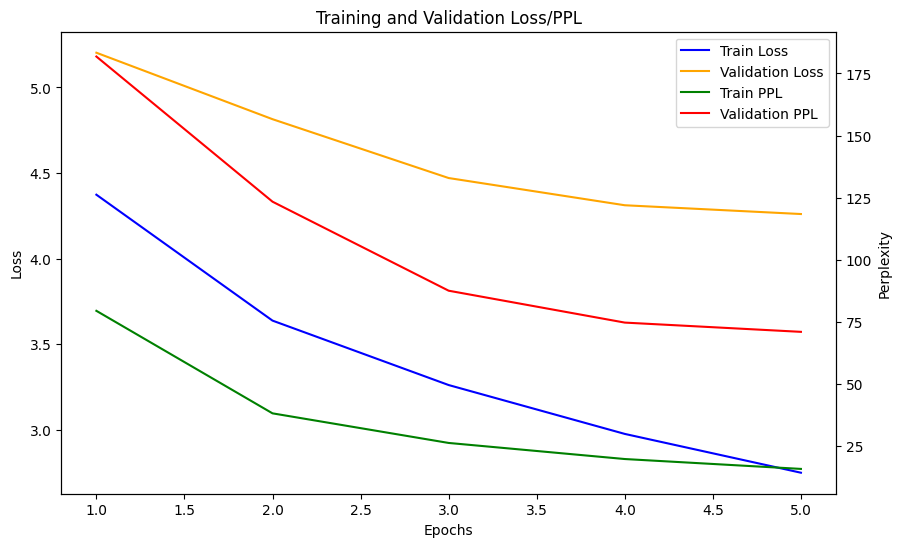

In [33]:
import matplotlib.pyplot as plt

# Create a list of epoch numbers
epochs = [epoch+1 for epoch in range(N_EPOCHS)]

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plotting the training and validation loss
ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
ax1.plot(epochs, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss/PPL')

# Plotting the training and validation perplexity
ax2.plot(epochs, train_PPLs, label='Train PPL', color='green')
ax2.plot(epochs, valid_PPLs, label='Validation PPL', color='red')
ax2.set_ylabel('Perplexity')

# Adjust the y-axis scaling for PPL plot
ax2.set_ylim(bottom=min(min(train_PPLs), min(valid_PPLs)) - 10, top=max(max(train_PPLs), max(valid_PPLs)) + 10)

# Set the legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')


# Show the plot
plt.show()


## Another Training with 10 Epochs to compare

In [34]:
torch.cuda.empty_cache()

N_EPOCHS = 10 #run the training for at least 5 epochs
CLIP = 1

best_valid_loss = float('inf')
best_train_loss = float('inf')
train_losses = []
valid_losses = []

train_PPLs = []
valid_PPLs = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    train_ppl = math.exp(train_loss)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    valid_ppl = math.exp(valid_loss)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN-TR-model.pt')

    train_losses.append(train_loss)
    train_PPLs.append(train_ppl)
    valid_losses.append(valid_loss)
    valid_PPLs.append(valid_ppl)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

Epoch: 01 | Time: 6m 36s
	Train Loss: 2.562 | Train PPL:  12.961
	 Val. Loss: 4.113 |  Val. PPL:  61.125


Epoch: 02 | Time: 6m 35s
	Train Loss: 2.415 | Train PPL:  11.193
	 Val. Loss: 4.150 |  Val. PPL:  63.448


Epoch: 03 | Time: 6m 35s
	Train Loss: 2.289 | Train PPL:   9.865
	 Val. Loss: 4.119 |  Val. PPL:  61.526


Epoch: 04 | Time: 6m 40s
	Train Loss: 2.177 | Train PPL:   8.824
	 Val. Loss: 4.140 |  Val. PPL:  62.814


Epoch: 05 | Time: 7m 10s
	Train Loss: 2.087 | Train PPL:   8.063
	 Val. Loss: 4.138 |  Val. PPL:  62.653


Epoch: 06 | Time: 7m 27s
	Train Loss: 2.003 | Train PPL:   7.411
	 Val. Loss: 4.099 |  Val. PPL:  60.276


Epoch: 07 | Time: 7m 15s
	Train Loss: 1.934 | Train PPL:   6.920
	 Val. Loss: 4.132 |  Val. PPL:  62.313


Epoch: 08 | Time: 7m 7s
	Train Loss: 1.870 | Train PPL:   6.487
	 Val. Loss: 4.163 |  Val. PPL:  64.275


Epoch: 09 | Time: 7m 7s
	Train Loss: 1.813 | Train PPL:   6.129
	 Val. Loss: 4.177 |  Val. PPL:  65.151


Epoch: 10 | Time: 7m 6s
	Train Loss: 1.770 | Train PPL:   5.873
	 Val. Loss: 4.193 |  Val. PPL:  66.217


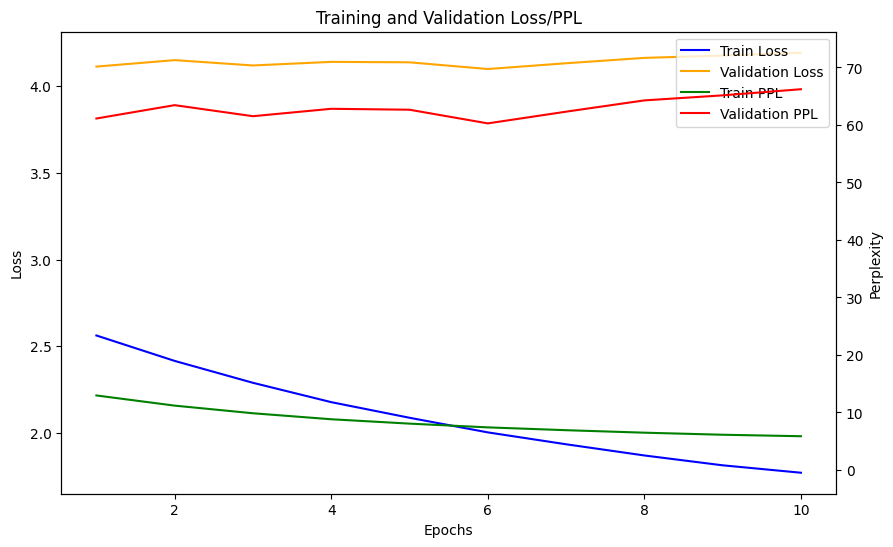

In [35]:
import matplotlib.pyplot as plt

# Create a list of epoch numbers
epochs = [epoch+1 for epoch in range(N_EPOCHS)]

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plotting the training and validation loss
ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
ax1.plot(epochs, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss/PPL')

# Plotting the training and validation perplexity
ax2.plot(epochs, train_PPLs, label='Train PPL', color='green')
ax2.plot(epochs, valid_PPLs, label='Validation PPL', color='red')
ax2.set_ylabel('Perplexity')

# Adjust the y-axis scaling for PPL plot
ax2.set_ylim(bottom=min(min(train_PPLs), min(valid_PPLs)) - 10, top=max(max(train_PPLs), max(valid_PPLs)) + 10)

# Set the legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')


# Show the plot
plt.show()

It can be seen that the loss and perplexity are decreasing as model gets trained. The validation loss starts to stabilize and then grow at Epoch 9, which suggests you do not need to continue training the model to avoid overtraining.


## Loading the saved model
If you want to skip training and load the pre-trained model instead, run the following cell:


In [36]:
# Download the model file
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/RNN-TR-model.pt'
filename = 'RNN-TR-model.pt'
urllib.request.urlretrieve(url, filename)

# Load the model state
model.load_state_dict(torch.load(filename, map_location=torch.device('cpu')))

<All keys matched successfully>

## Model inference


Next, create a generator function that generates translations for input source sentences:


In [37]:
import torch.nn.functional as F

def generate_translation(model, src_sentence, src_vocab, trg_vocab, max_len=50):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        src_tensor = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(device)

        # Pass the source tensor through the encoder
        hidden, cell = model.encoder(src_tensor)

        # Create a tensor to store the generated translation
        # get_stoi() maps tokens to indices
        trg_indexes = [trg_vocab.get_stoi()['<bos>']]  # Start with <bos> token

        # Convert the initial token to a PyTorch tensor
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1)  # Add batch dimension

        # Move the tensor to the same device as the model
        trg_tensor = trg_tensor.to(model.device)


        # Generate the translation
        for _ in range(max_len):

            # Pass the target tensor and the previous hidden and cell states through the decoder
            output, hidden, cell = model.decoder(trg_tensor[-1], hidden, cell)

            # Get the predicted next token
            pred_token = output.argmax(1)[-1].item()

            # Append the predicted token to the translation
            trg_indexes.append(pred_token)


            # If the predicted token is the <eos> token, stop generating
            if pred_token == trg_vocab.get_stoi()['<eos>']:
                break

            # Convert the predicted token to a PyTorch tensor
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1)  # Add batch dimension

            # Move the tensor to the same device as the model
            trg_tensor = trg_tensor.to(model.device)

        # Convert the generated tokens to text
        # get_itos() maps indices to tokens
        trg_tokens = [trg_vocab.get_itos()[i] for i in trg_indexes]

        # Remove the <sos> and <eos> from the translation
        if trg_tokens[0] == '<bos>':
            trg_tokens = trg_tokens[1:]
        if trg_tokens[-1] == '<eos>':
            trg_tokens = trg_tokens[:-1]

        # Return the translation list as a string

        translation = " ".join(trg_tokens)

        return translation

Now, you can check the model's output for a sample sentence:


In [38]:
# model.load_state_dict(torch.load('RNN-TR-model.pt'))

# Actual translation: Asian man sweeping the walkway.
src_sentence = 'Ein asiatischer Mann kehrt den Gehweg.'


generated_translation = generate_translation(model, src_sentence=src_sentence, src_vocab=vocab_transform['de'], trg_vocab=vocab_transform['en'], max_len=12)
#generated_translation = " ".join(generated_translation_list).replace("<bos>", "").replace("<eos>", "")
print(generated_translation)


An Asian man is on the sidewalk .


Fantastic! You have created a translation model that can generate german-english translations pretty accurate, huh?

You can play with the model parameters and hyperparameters to improve the model performance.


## BLEU score metric for evaluation
While peplexity serves as a general metric to evaluate the performance of language model in predicting the correct next token, BLEU score is helpful in evaluating the quality of the final generated translation.
Validating the results using BLEU score is helpful when there is more than a single valid translation for a sentence as you can include many translation versions in the reference list and compare the generated translation with different versions of translations.

The BLEU (Bilingual Evaluation Understudy) score is a metric commonly used to evaluate the quality of machine-generated translations by comparing them to one or more reference translations. It measures the similarity between the generated translation and the reference translations based on n-gram matching.

The BLEU score is calculated using the following formulas:

1. **Precision**:
   - Precision measures the proportion of n-grams in the generated translation that appear in the reference translations.
   - Precision is calculated for each n-gram order (1 to N) and then combined using a geometric mean.
   - The precision for a particular n-gram order is calculated as:
   
   $$\text{Precision}_n(t) = \frac{\text{CountClip}_n(t)}{\text{Count}_n(t)}$$
   
   where:
     - $\text{CountClip}_n(t)$ is the count of n-grams in the generated translation that appear in any reference translation, clipped by the maximum count of that n-gram in any single reference translation.
     - $\text{Count}_n(t)$ is the count of n-grams in the generated translation.

2. . **Brevity penalty**:
   - The brevity penalty accounts for the fact that shorter translations tend to have higher precision scores.
   - It encourages translations that are closer in length to the reference translations.
   - The brevity penalty is calculated as:
   
  $$\text{BP} = \begin{cases} 1 & \text{if } c > r \\\\\\\\\\\\\\\\\\\\\\ e^{(1 - \frac{r}{c})} & \text{if } c \leq r \end{cases}$$
   
   where:
     - $c$ is the total length of the generated translation.
     - $r$ is the total length of the reference translations.

3. **BLEU score**:
   - The BLEU score is the geometric mean of the precisions, weighted by the brevity penalty.
   - It is calculated as:
   
   $$\text{BLEU} = \text{BP} \cdot \exp(\sum_{n=1}^{N}w_n \log(\text{Precision}_n(t)))$$
   
   where:
     - $N$ is the maximum n-gram order.
     - $w_n$ is the weight assigned to the precision at n-gram order $n$, commonly set as $\frac{1}{N}$ for equal weights.


In [39]:
def calculate_bleu_score(generated_translation, reference_translations):
    # Convert the generated translations and reference translations into the expected format for sentence_bleu
    references = [reference.split() for reference in reference_translations]
    hypothesis = generated_translation.split()

    # Calculate the BLEU score
    bleu_score = sentence_bleu(references, hypothesis)

    return bleu_score

Let's calculate the BLEU score for a sample sentence:


In [40]:
reference_translations = [
    "Asian man sweeping the walkway .",
    "An asian man sweeping the walkway .",
    "An Asian man sweeps the sidewalk .",
    "An Asian man is sweeping the sidewalk .",
    "An asian man is sweeping the walkway .",
    "Asian man sweeping the sidewalk ."
]

bleu_score = calculate_bleu_score(generated_translation, reference_translations)
print("BLEU Score:", bleu_score)

BLEU Score: 0.5


# Exercises


### Exercise 1 - Translate a German sentence to English.


In [41]:
# Define the German text to be translated
german_text = "Menschen gehen auf der Straße"
# TO DO
# The function should be defined to accept the text, the model, source and target vocabularies, and the device as parameters.
english_translation = generate_translation(
    model, 
    src_sentence=german_text, 
    src_vocab=vocab_transform['de'], 
    trg_vocab=vocab_transform['en'], 
    max_len=50
)

# Display the original and translated text
print(f"Original German text: {german_text}")
print(f"Translated English text: {english_translation}")

Original German text: Menschen gehen auf der Straße
Translated English text: People are walking on the street .


## Authors


[Fateme Akbari](https://www.linkedin.com/in/fatemeakbari/) is a PhD candidate in Information Systems at McMaster University with demonstrated research experience in Machine Learning and NLP.


<h2 id="Contributors"><a href="#Table-of-Contents">Contributors</a></h2>

[Hailey Quach](https://www.haileyq.com/)

<h2 id="Change-Log"><a href="#Table-of-Contents">Change Log</a></h2>


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2025-03-13|1.1|Hailey Quach|Updated lab|


© Copyright IBM Corporation. All rights reserved.
